# Evaluate NWChem Cost vs Accuracy
This notebook plots the data from the tests of MP2 with different basis sets run at different scales.
The goal is to establish cost/accuracy tradeoffs and determine the optimal level of scaling

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import cm 
from ttm.ase import TTMCalculator
from io import StringIO
from ase.io import read
import pandas as pd
import numpy as np
import json

Lookup data

In [2]:
monomer_energies = {
    'aug-cc-pv5z': -76.36022823,
    'aug-cc-pvqz': -76.35191864,
    'aug-cc-pvtz': -76.32899240,
    'aug-cc-pvdz': -76.26090977
}

## Load in the Data
All of our run performance is written to a CSV file

In [3]:
results = pd.read_csv('runtimes.csv')
results.tail()

,id,hostname,ranks_per_node,basis,n_waters,ttm_energy,mp2_energy,runtime,num_nodes,gradients,dftguess,direct
260,625ea5cc4285bda750b6b407,login,128,aug-cc-pvtz,10,-86.567055,-763.449313,1472.647023,2,"[[0.12464709062732508, 0.31573149193555117, 0....",False,NaN
261,625eabf04285bda750bb5fa4,login,128,aug-cc-pvtz,16,-167.249741,-1221.565460,8822.435326,2,"[[-0.4136905297429168, 0.27145709217064734, 0....",False,NaN
262,625eabf04285bda750bb5fa5,login,128,aug-cc-pvtz,16,-167.179718,-1221.564959,8798.787508,2,"[[-0.15051239037383685, -0.4707690242133503, 0...",False,NaN
263,625eacc34285bda750bbdd53,login,128,aug-cc-pvtz,16,-158.685608,-1221.550791,9103.936278,2,"[[-0.20131739265923174, -0.611099845303272, -0...",False,NaN
264,625ead614285bda750bc3a15,login,128,aug-cc-pvtz,16,-156.212463,-1221.543847,9255.555785,2,"[[-0.2728454879820903, 0.04730830172324219, -0...",False,NaN


Each row is a different test from a different molecule in the HydroNet database.

Convert the energies to energy/water in kcal/mol

In [4]:
results['ttm_energy_per_water'] = results['ttm_energy'] / results['n_waters']
results['mp2_energy_per_water'] = results['mp2_energy'] * 627.5 / results['n_waters']

Compute the binding energy

In [5]:
results['ttm_binding_energy'] = results['ttm_energy']
results['mp2_binding_energy'] = (results['mp2_energy'] - results['basis'].apply(monomer_energies.get) * results['n_waters']) * 627.5

In [6]:
results['ttm_binding_energy_atom'] = results['ttm_binding_energy'] / results['n_waters']
results['mp2_binding_energy_atom'] = results['mp2_binding_energy'] / results['n_waters']

Subtract off the energy of a square cluster to normalize to energies across cluster sizes

In [7]:
sq_energy = results.query('id == "625ea59e4285bda750b679a2"').drop_duplicates('basis')
sq_energy_ttm = results['ttm_energy_per_water'].min()
sq_energy = dict(zip(sq_energy['basis'], sq_energy['mp2_energy_per_water']))

In [8]:
results['mp2_energy_above_sq'] = results['mp2_energy_per_water'] - results['basis'].apply(sq_energy.get)
results['ttm_energy_above_sq'] = results['ttm_energy_per_water'] - sq_energy_ttm

Substract off the first energy in the cluster 

In [9]:
results['mp2_energy_above_min'] = results['mp2_energy_per_water'] - results.sort_values('ttm_energy').groupby(['basis', 'n_waters'])['mp2_energy_per_water'].transform(lambda x: x.iloc[0])
results['ttm_energy_above_min'] = results['ttm_energy_per_water'] - results.sort_values('ttm_energy').groupby(['basis', 'n_waters'])['ttm_energy_per_water'].transform(lambda x: x.iloc[0])

### Get the TTM Gradients
We'll compute them using the structures for each row

In [10]:
# Make a dictionary where the key is the ID of a structure of value is the XYZ-format structure
xyzs = dict(pd.read_csv('../example_structures.csv').apply(lambda x: (x['id'], x['xyz']), axis=1).tolist())

In [11]:
ttm = TTMCalculator()

In [12]:
from ase.units import kcal, mol
def get_gradients(str_id: str) -> np.ndarray:
    """Compute the gradients of a structure with a TTM potential
    
    Args:
        str_id: MongoDB structure ID
    Returns:
        Gradients
    """
    if str_id in xyzs:
        atoms = read(StringIO(xyzs[str_id]), format='xyz')
        grads = ttm.get_forces(atoms)
        grads *= kcal / mol
        return grads

In [13]:
results['ttm_gradients'] = results['id'].apply(get_gradients)

## Compare Accuracies of Different Basis Sets
We're going to get one entry per basis set and cluster id

In [14]:
accuracy_results = results.drop_duplicates(['id', 'basis'])
print(f'Found {len(accuracy_results)} relevant records')

Found 44 relevant records


Make a plot comparing everyone

In [15]:
bases = ['aug-cc-pvdz', 'aug-cc-pvtz', 'aug-cc-pvqz']
n_col = len(bases)

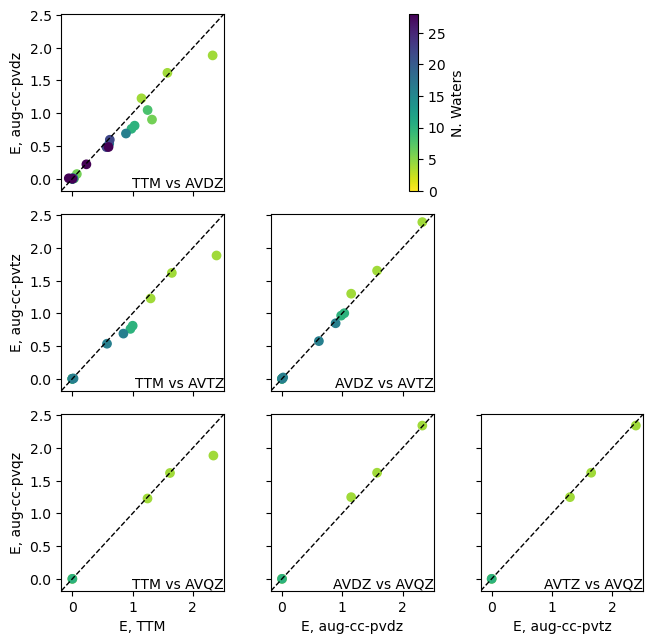

In [16]:
fig, axs = plt.subplots(n_col, n_col, figsize=(6.5, 6.5), sharex=True, sharey=True)

column = 'energy_above_min'

# Make the plot settings
vmin = 0 # accuracy_results['n_waters'].min()
vmax = accuracy_results['n_waters'].max()
plot_kwargs = dict(cmap='viridis_r', vmin=vmin, vmax=vmax)

# First column is vs TTM
for b, ax in zip(bases, axs[:, 0]):
    subset = accuracy_results.query(f'basis=="{b}"')
    
    l = ax.scatter(subset[f'mp2_{column}'], subset[f'ttm_{column}'], c=subset['n_waters'], **plot_kwargs)
    ax.set_ylabel(f'E, {b}')
    
    ax.text(1, 0, f'TTM vs A{b[-3:].upper()}', ha='right', va='bottom', transform=ax.transAxes)
axs[-1, 0].set_xlabel('E, TTM')

# Later columns are MP2
for i, b1 in enumerate(bases[:-1]):  # Start from the lowest basis
    # Make the axis label    
    axs[-1, i+1].set_xlabel(f'E, {b1}')
    
    # Get the energies at the low level of accuracy
    subset_low = accuracy_results.query(f'basis=="{b1}"')

    for j, b2 in enumerate(bases[i+1:]):
        # Get the dataset for the high level of accuracy
        subset_high = accuracy_results.query(f'basis=="{b2}"')
        
        # Join on the cluster ID
        merged = subset_low.merge(subset_high, on='id', suffixes=('_low', '_high'))
        ax = axs[i+j+1, i+1]
        ax.scatter(merged[f'mp2_{column}_low'], merged[f'mp2_{column}_high'], c=merged['n_waters_high'], **plot_kwargs)
        
        # Make a label
        ax.text(1, 0, f'A{b1[-3:].upper()} vs A{b2[-3:].upper()}', ha='right', va='bottom',
                transform=ax.transAxes)
        
# Define the plot limits
min_eng = accuracy_results[[f'ttm_{column}', f'mp2_{column}']].values.min()
max_eng = accuracy_results[[f'ttm_{column}', f'mp2_{column}']].values.max()
offset = (max_eng - min_eng) * 0.05
axs[0, 0].set_xlim([min_eng - offset, max_eng + offset])
axs[0, 0].set_ylim(axs[0, 0].get_xlim())
        
# Format the cells
for i in range(n_col):
    for j in range(n_col):
        if j > i:
            axs[i, j].axis('off')
        else:
            axs[i, j].plot(ax.get_xlim(), ax.get_ylim(), 'k--', lw=1)

# Make a colorbar
fig.colorbar(l, ax=axs[0, 1], label='N. Waters')
fig.tight_layout()

### Repeat the analysis, but with gradients
We haven't done as many tests with gradients, as this is something I started later

In [17]:
accuracy_results = results[~results.gradients.isnull()].drop_duplicates(['id', 'basis'])
print(f'Found {len(accuracy_results)} relevant records')

Found 37 relevant records


Parse the gradients using JSON

In [18]:
accuracy_results['gradients'] = accuracy_results['gradients'].apply(json.loads)

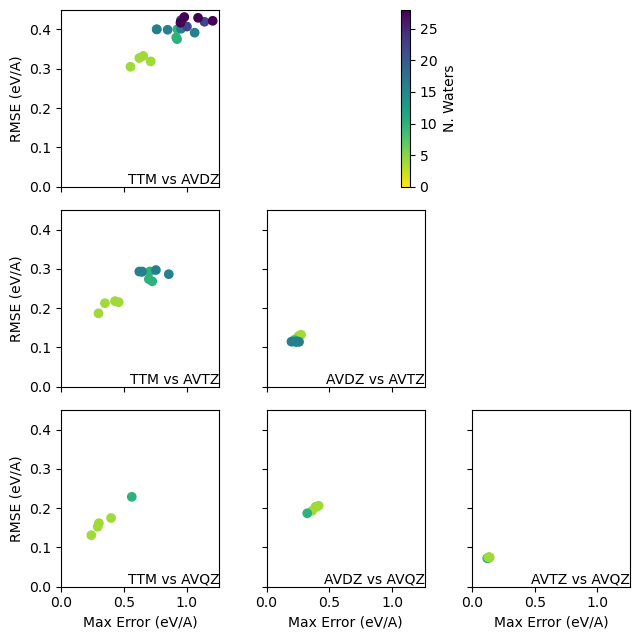

In [19]:
fig, axs = plt.subplots(n_col, n_col, figsize=(6.5, 6.5), sharex=True, sharey=True)

# Make the plot settings
vmin = 0 # accuracy_results['n_waters'].min()
vmax = accuracy_results['n_waters'].max()
plot_kwargs = dict(cmap='viridis_r', vmin=vmin, vmax=vmax)

# First column is vs TTM
for b, ax in zip(bases, axs[:, 0]):
    subset = accuracy_results.query(f'basis=="{b}"')
    
    # Compute the errors between each
    errors = [np.subtract(x, y) for x, y in zip(subset['gradients'], subset['ttm_gradients'])]
    max_errors = [np.max(e) for e in errors]
    rmse_errors = [np.sqrt(np.power(e, 2).mean()) for e in errors]
    
    l = ax.scatter(max_errors, rmse_errors, c=subset['n_waters'], **plot_kwargs)
    ax.set_ylabel(f'RMSE (eV/A)')
    
    ax.text(1, 0, f'TTM vs A{b[-3:].upper()}', ha='right', va='bottom', transform=ax.transAxes)
axs[-1, 0].set_xlabel('Max Error (eV/A)')

# Later columns are MP2
for i, b1 in enumerate(bases[:-1]):  # Start from the lowest basis
    # Make the axis label    
    axs[-1, i+1].set_xlabel('Max Error (eV/A)')
    
    # Get the energies at the low level of accuracy
    subset_low = accuracy_results.query(f'basis=="{b1}"')
    
    for j, b2 in enumerate(bases[i+1:]):
        # Get the dataset for the high level of accuracy
        subset_high = accuracy_results.query(f'basis=="{b2}"')
        
        # Join on the cluster ID
        merged = subset_low.merge(subset_high, on='id', suffixes=('_low', '_high'))
        
        # Compute the errors between each
        errors = [np.subtract(x, y) for x, y in zip(merged['gradients_low'], merged['gradients_high'])]
        max_errors = [np.max(e) for e in errors]
        rmse_errors = [np.sqrt(np.power(e, 2).mean()) for e in errors]
        
        ax = axs[i+j+1, i+1]
        ax.scatter(max_errors, rmse_errors, c=merged['n_waters_high'], **plot_kwargs)

        # Label the plot
        ax.text(1, 0, f'A{b1[-3:].upper()} vs A{b2[-3:].upper()}', ha='right', va='bottom',
                transform=ax.transAxes)
        
# Format the cells
for i in range(n_col):
    for j in range(n_col):
        if j > i:
            axs[i, j].axis('off') 
            
ax.set_xlim([0, ax.get_xlim()[1]])
ax.set_ylim([0, ax.get_ylim()[1]])

# Make a colorbar
fig.colorbar(l, ax=axs[0, 1], label='N. Waters')
fig.tight_layout()
fig.savefig('figures/forces-comparison.png', dpi=320)

## Evaluate Scaling
Plot how well we scale for different basis sets

### Narrow down to Perlmutter runs
We only want runs on Perlmutter CPU with 128 ranks per node.

In [20]:
perl = results.query('hostname=="login" and ranks_per_node==128')
print(f'Found {len(perl)} relevant entries.')

Found 40 relevant entries.


### Compute the scaling efficiency
Average the runtime for each cluster for each basis set at each number of nodes

In [21]:
# We use extra fields `groupby` to get additional columns in the output
# Converting the result of `mean` from a Series to a DataFrame, then calling reset index to make it a single-index array 
#  gives me a kind of DataFrame I'm most comfortable working with
avg_results = pd.DataFrame(perl.groupby(['id', 'basis', 'num_nodes', 'n_waters', 'dftguess'])['runtime'].mean()).reset_index()

Compute the scaling efficiency

In [22]:
# We sort to put the runs with the fewest nodes first
#  Then groupby on id / basis to get each test case
#  and use transform to get the node-hours for the best case
avg_results['ideal_node-s'] = avg_results.sort_values('num_nodes', ascending=True).groupby(['id', 'basis', 'dftguess']).transform(lambda x: x.iloc[0])[['runtime', 'num_nodes']].prod(axis=1)

In [23]:
# The ideal runtime is the ideal_node-s divided by the number of nodes
avg_results['ideal_runtime'] = avg_results['ideal_node-s'] / avg_results['num_nodes']

In [24]:
# The scaling efficiency is the ratio of this ideal runtime to what we observed
avg_results['efficiency'] = avg_results['ideal_runtime'] / avg_results['runtime']

Plot the efficiency with node count

/tmp/ipykernel_780460/2333307717.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis_r')
/tmp/ipykernel_780460/2333307717.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_subset = group.groupby('num_nodes').mean()
/tmp/ipykernel_780460/2333307717.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_subset = group.groupby('num_nodes').mean()
/tmp/ipykernel_780460/2333307717.py:13: FutureWarning: T

Text(0, 0.5, 'Efficiency (%)')

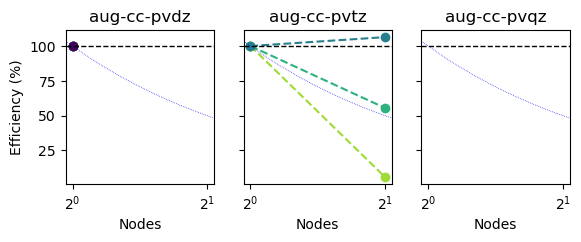

In [25]:
fig, axs = plt.subplots(1, n_col, sharey=True, sharex=True, figsize=(6.5, 2.))

cmap = cm.get_cmap('viridis_r')

# Loop over basis sets
for ax, b in zip(axs, bases):
    subset = avg_results.query(f'basis=="{b}" and not dftguess')
    ax.set_title(b)
  
    # Loop over sizes of water clusters
    for size, group in subset.groupby('n_waters'):
        # Get the average efficiency for each node count
        mean_subset = group.groupby('num_nodes').mean()
        
        # Determine color based on numebr of molecules
        color = cmap((size - vmin) / (vmax - vmin))
        ax.plot(mean_subset.index, mean_subset['efficiency'] * 100, '--o', c=color)
    
    ax.set_xscale('log', base=2)
    
# Make a line at 100%
for ax in axs:
    # Fix our current sizes
    ax.set_ylim(ax.get_ylim())
    ax.set_xlim(ax.get_xlim())
    
    ax.plot(ax.get_xlim(), [100]*2, 'k--', lw=1)
    
    # Make a 'fail' line
    x = np.logspace(*np.log10(ax.get_xlim()), 128)
    ax.plot(x, 100./x, 'b:', lw=0.5)
    
    ax.set_xlabel('Nodes')

axs[0].set_ylabel('Efficiency (%)')

## Plot the runtimes
We want a comparative runtimes for different basis sets. We're going to compare minimum node hours required to run a computation and the minimum number of nodes required to finish in under an hour

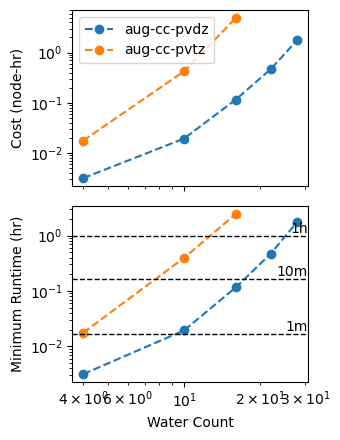

In [26]:
fig, axs = plt.subplots(2, 1, figsize=(3.5, 4.5), sharex=True)

# Plot the minimum node hours required to complete a calculation by size
for bid, group in avg_results.groupby('basis'):
    min_group = group.groupby('n_waters')['ideal_node-s'].min()
    
    axs[0].loglog(min_group.index, min_group / 3600,  '--o', label=bid)
    
axs[0].legend()
axs[0].set_ylabel('Cost (node-hr)')

# Plot the minimum wallclock time achievable with >75% efficiency
acc_results = avg_results.query('efficiency > 0.5')

for bid, group in acc_results.groupby('basis'):
    min_group = group.groupby('n_waters')['runtime'].min()
    
    axs[1].loglog(min_group.index, min_group / 3600,  '--o', label=bid)
axs[1].set_ylabel('Minimum Runtime (hr)')

axs[1].set_xlim(axs[1].get_xlim())
    
# Ad in marks at human-friendly times
for t, l in zip([1./60, 10./60, 1.], ['1m', '10m', '1h']):
    axs[1].plot(axs[1].get_xlim(), [t]*2, 'k--', lw=1)
    axs[1].text(axs[1].get_xlim()[1], t, l, ha='right', va='bottom')


axs[-1].set_xlabel('Water Count')
fig.tight_layout()
fig.savefig('figures/runtime-vs-size.png', dpi=320)

In [27]:
avg_results.groupby(['basis', 'num_nodes', 'n_waters']).mean(numeric_only=True)\
    .sort_values('runtime').reset_index().drop_duplicates(('n_waters', 'basis'), keep='first').sort_values('basis')

,basis,num_nodes,n_waters,dftguess,runtime,ideal_node-s,ideal_runtime,efficiency
0,aug-cc-pvdz,1,4,0.0,24.136156,24.136156,24.136156,1.000000
2,aug-cc-pvdz,1,10,0.0,101.755819,101.755819,101.755819,1.000000
3,aug-cc-pvdz,1,16,0.0,426.703095,426.703095,426.703095,1.000000
7,aug-cc-pvdz,1,22,0.0,1729.326351,1729.326351,1729.326351,1.000000
8,aug-cc-pvdz,1,28,0.0,6504.923328,6504.923328,6504.923328,1.000000
1,aug-cc-pvtz,1,4,0.0,64.959086,64.959086,64.959086,1.000000
5,aug-cc-pvtz,2,10,0.0,1478.312875,1641.008315,820.504158,0.555132
9,aug-cc-pvtz,2,16,0.0,8995.178724,19119.182191,9559.591096,1.063975


## Assess Using DFT-Based WFC Guess
Make sure that we get the same ansewr with or without using DFT to make the initial guess of workflows

In [28]:
count = 0
has_grads = (~results['gradients'].isnull())
for gid, group in results[has_grads].drop_duplicates(['id', 'basis', 'dftguess']).groupby(['id', 'basis']):
    if len(group) < 2:
        continue
    count += 1
    assert np.isclose(group['mp2_energy'].iloc[0], group['mp2_energy'].iloc[1])
    assert np.isclose(
        json.loads(group['gradients'].iloc[0]),
        json.loads(group['gradients'].iloc[1]),
        atol=1e-4,  # Use this as the cutoff, I've seen differences of O(1e-5)
    ).all()
print(f'Energies and gradients match for {count} structures')

Energies and gradients match for 30 structures


See if there's a speedup

In [29]:
with_guess = avg_results.query('dftguess')
without_guess = avg_results.query('not dftguess')

In [30]:
compare_guess = with_guess.merge(
    without_guess, on=('id', 'basis', 'num_nodes', 'n_waters'),
    suffixes=('_guess', '_noguess'), 
)

In [31]:
compare_guess['speedup'] = compare_guess['runtime_noguess'] / compare_guess['runtime_guess']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


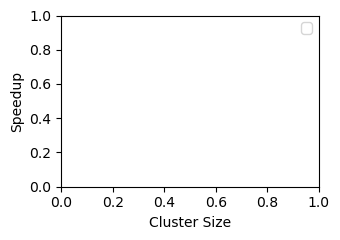

In [32]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

subset = compare_guess.query('num_nodes==4')

for basis, group in compare_guess.groupby('basis'):
    values = group.groupby('n_waters')['speedup'].median()
    ax.plot(values.index, values.values, '--o', label=basis)
    
ax.set_xlabel('Cluster Size')
ax.set_ylabel('Speedup')
ax.legend()

fig.tight_layout()

In [33]:
compare_guess.groupby(['basis', 'n_waters', 'num_nodes'])['speedup'].mean()

Series([], Name: speedup, dtype: float64)